In [15]:
%pip install yfinance pandas_ta scikit-learn matplotlib statsmodels


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: C:\Users\sparsh\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:

import yfinance as yf
import statsmodels.api as sm

symbols = [
  "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS", "AXISBANK.NS",
  "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS",
  "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS",
  "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS",
  "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "ITC.NS",
  "INDUSINDBK.NS", "INFY.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LTIM.NS",
  "LT.NS", "M&M.NS", "MARUTI.NS", "NTPC.NS", "NESTLEIND.NS",
  "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBILIFE.NS", "SBIN.NS",
  "SUNPHARMA.NS", "TCS.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS",
  "TECHM.NS", "TITAN.NS", "UPL.NS", "ULTRACEMCO.NS", "WIPRO.NS"
]


df = yf.download(symbols, start="2000-01-01")['Close'].dropna()

# df = yf.download(symbols, interval="1m", period="7d")['Close'].dropna()

print(df.head())

[*********************100%***********************]  50 of 50 completed

Ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
Date                                                                   
2017-11-17    83.979111     384.685059    1029.646118    1109.959839   
2017-11-20    86.016914     382.430359    1034.282715    1105.269165   
2017-11-21    82.289848     384.541138    1081.331055    1099.536011   
2017-11-22    84.622612     397.685364    1122.034668    1112.802856   
2017-11-23    81.780418     390.585571    1112.322510    1098.872437   

Ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
Date                                                                   
2017-11-17   539.377197    2637.365967     511.470154    1751.500610   
2017-11-20   542.111816    2666.274414     515.837341    1769.041748   
2017-11-21   543.752502    2714.179932     519.092651    1773.451538   
2017-11-22   537.487671    2724.830078     516.116516    1738.369385   
2017-11-23   541.117371    2684.901855     511.854065    1728.2

In [19]:
# Filtering out correlated stocks.

filtered_pairs = []
corr_matrix = df.corr()
corr_threshold = 0.8

for i in range(len(symbols)):
  for j in range(i + 1, len(symbols)):
    s1, s2 = symbols[i], symbols[j]
    corr = corr_matrix.loc[s1, s2]
    if corr > corr_threshold:
      filtered_pairs.append((s1, s2, corr))

# Sort by correlation
filtered_pairs.sort(key=lambda x: x[2], reverse=True)

# Output top correlated pairs
for s1, s2, corr in filtered_pairs:
  print(f"{s1} & {s2} → Corr: {corr}")

COALINDIA.NS & NTPC.NS → Corr: 0.9845456713048241
NTPC.NS & POWERGRID.NS → Corr: 0.9839112130457521
POWERGRID.NS & SUNPHARMA.NS → Corr: 0.9802343190174795
INFY.NS & TCS.NS → Corr: 0.9763052920082298
BAJFINANCE.NS & BAJAJFINSV.NS → Corr: 0.975600604483178
COALINDIA.NS & ONGC.NS → Corr: 0.9753271792689514
BHARTIARTL.NS & SUNPHARMA.NS → Corr: 0.9739461953214412
GRASIM.NS & ULTRACEMCO.NS → Corr: 0.9739045022237262
GRASIM.NS & HINDALCO.NS → Corr: 0.9737223486691388
BAJAJ-AUTO.NS & NTPC.NS → Corr: 0.9735785837972202
APOLLOHOSP.NS & HCLTECH.NS → Corr: 0.9734649087976937
BAJAJ-AUTO.NS & POWERGRID.NS → Corr: 0.9728456343527219
HCLTECH.NS & ULTRACEMCO.NS → Corr: 0.9723810244696048
APOLLOHOSP.NS & ICICIBANK.NS → Corr: 0.971117508386635
ICICIBANK.NS & SBIN.NS → Corr: 0.9709954347215288
GRASIM.NS & SBIN.NS → Corr: 0.9709507122516232
INFY.NS & LTIM.NS → Corr: 0.9690843447227012
APOLLOHOSP.NS & JSWSTEEL.NS → Corr: 0.9683921760138953
LT.NS & NTPC.NS → Corr: 0.9683470729976014
APOLLOHOSP.NS & TITAN.NS 

In [20]:
# Filtering the co-integrated stocks

import pandas as pd
from statsmodels.tsa.stattools import coint

# Taking only 20 highest correlated stocks
# We can change it according to our needs.
filtered_pairs = filtered_pairs[:50]

co_integrated_pairs = []

for stock1, stock2, _ in filtered_pairs:
  prices1 = df[stock1].dropna()
  prices2 = df[stock2].dropna()
  
  # Align on common dates
  combined = pd.concat([prices1, prices2], axis=1).dropna()
  prices1_aligned = combined.iloc[:, 0]
  prices2_aligned = combined.iloc[:, 1]
  
  # Run cointegration test
  _, p_coint, _ = coint(prices1_aligned, prices2_aligned)
  if p_coint < 0.05:
    co_integrated_pairs.append((stock1, stock2, round(p_coint, 4)))

# Sorting by strongest co-integration
co_integrated_pairs.sort(key=lambda x: x[2])

for s1, s2, p in co_integrated_pairs:
  print(f"{s1} & {s2} → Cointegration p-value: {p}")

  


GRASIM.NS & HINDALCO.NS → Cointegration p-value: 0.0004
ADANIPORTS.NS & CIPLA.NS → Cointegration p-value: 0.0033
HCLTECH.NS & ULTRACEMCO.NS → Cointegration p-value: 0.0035
RELIANCE.NS & TATACONSUM.NS → Cointegration p-value: 0.0035
EICHERMOT.NS & M&M.NS → Cointegration p-value: 0.0073
APOLLOHOSP.NS & ULTRACEMCO.NS → Cointegration p-value: 0.0088
BAJAJ-AUTO.NS & POWERGRID.NS → Cointegration p-value: 0.009
CIPLA.NS & HCLTECH.NS → Cointegration p-value: 0.0099
APOLLOHOSP.NS & JSWSTEEL.NS → Cointegration p-value: 0.0111
ICICIBANK.NS & SBILIFE.NS → Cointegration p-value: 0.0166
NTPC.NS & POWERGRID.NS → Cointegration p-value: 0.0199
INFY.NS & TCS.NS → Cointegration p-value: 0.0211
COALINDIA.NS & ONGC.NS → Cointegration p-value: 0.0234
POWERGRID.NS & SUNPHARMA.NS → Cointegration p-value: 0.025
HINDALCO.NS & JSWSTEEL.NS → Cointegration p-value: 0.0279
SBIN.NS & TATASTEEL.NS → Cointegration p-value: 0.0296
SBIN.NS & ULTRACEMCO.NS → Cointegration p-value: 0.0409
APOLLOHOSP.NS & TCS.NS → Cointegr

In [21]:
print(co_integrated_pairs)

[('GRASIM.NS', 'HINDALCO.NS', 0.0004), ('ADANIPORTS.NS', 'CIPLA.NS', 0.0033), ('HCLTECH.NS', 'ULTRACEMCO.NS', 0.0035), ('RELIANCE.NS', 'TATACONSUM.NS', 0.0035), ('EICHERMOT.NS', 'M&M.NS', 0.0073), ('APOLLOHOSP.NS', 'ULTRACEMCO.NS', 0.0088), ('BAJAJ-AUTO.NS', 'POWERGRID.NS', 0.009), ('CIPLA.NS', 'HCLTECH.NS', 0.0099), ('APOLLOHOSP.NS', 'JSWSTEEL.NS', 0.0111), ('ICICIBANK.NS', 'SBILIFE.NS', 0.0166), ('NTPC.NS', 'POWERGRID.NS', 0.0199), ('INFY.NS', 'TCS.NS', 0.0211), ('COALINDIA.NS', 'ONGC.NS', 0.0234), ('POWERGRID.NS', 'SUNPHARMA.NS', 0.025), ('HINDALCO.NS', 'JSWSTEEL.NS', 0.0279), ('SBIN.NS', 'TATASTEEL.NS', 0.0296), ('SBIN.NS', 'ULTRACEMCO.NS', 0.0409), ('APOLLOHOSP.NS', 'TCS.NS', 0.042), ('APOLLOHOSP.NS', 'TITAN.NS', 0.0422), ('SUNPHARMA.NS', 'ULTRACEMCO.NS', 0.048)]


In [22]:
"""
# Before moving to another step of using OLS to find beta. It is important to identify the dependent and independent stock.

Say you are analyzing:
- Stock A: ICICIBANK (stable, large-cap, low volatility)
- Stock B: HDFCBANK (more volatile)

Wrong Way:
-----------
- ICICIBANK = alpha + beta * HDFCBANK
- You're trying to model how the stable stock depends on the noisy one.

This gives:
- Poor beta
- Non-stationary spread
- Bad trading signals

Right Way:
-----------
- HDFCBANK = alpha + beta * ICICIBANK
- You're modeling how the noisier stock reacts to the stable one.

This gives:
- Accurate hedge ratio (β)
- Clean, mean-reverting spread
- Reliable entry/exit signals
"""

from statsmodels.tsa.stattools import adfuller, kpss

tradable_pairs = []

for stockOne, stockTwo, _ in co_integrated_pairs:

  dependentStock = None
  independentStock = None

  dailyReturns = df.pct_change().dropna()
  volatilityStockOne = dailyReturns[stockOne].std()
  volatilityStockTwo = dailyReturns[stockTwo].std()
  
  if volatilityStockOne > volatilityStockTwo:
    dependentStock = stockOne
    independentStock = stockTwo
  else:
    dependentStock = stockTwo
    independentStock = stockOne
  
  X = sm.add_constant(df[independentStock])
  model = sm.OLS(df[dependentStock], X).fit()
  beta = model.params[independentStock]
  
  spread = df[dependentStock] - beta * df[independentStock]

  adf_p_value = adfuller(spread)[1]
  kpss_p_value = kpss(spread, regression='c')[1]
  
  print(f'Dependent Stock = {dependentStock}, Independent Stock = {independentStock}, Beta = {beta}, ADF p-value = {adf_p_value}, KPSS p-value = {kpss_p_value}')

  if adf_p_value < 0.05 and kpss_p_value > 0.05:
    tradable_pairs.append((dependentStock, independentStock))
    
print(tradable_pairs)


Dependent Stock = HINDALCO.NS, Independent Stock = GRASIM.NS, Beta = 0.26342611893574486, ADF p-value = 2.5721982347500572e-05, KPSS p-value = 0.02589063157101867
Dependent Stock = ADANIPORTS.NS, Independent Stock = CIPLA.NS, Beta = 0.9498383691858472, ADF p-value = 0.0005940815773537786, KPSS p-value = 0.1


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]
C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = ULTRACEMCO.NS, Independent Stock = HCLTECH.NS, Beta = 5.814186823561754, ADF p-value = 0.0009543733843526448, KPSS p-value = 0.1
Dependent Stock = TATACONSUM.NS, Independent Stock = RELIANCE.NS, Beta = 0.9122875991176125, ADF p-value = 0.0013217630998806724, KPSS p-value = 0.011283740474555907
Dependent Stock = M&M.NS, Independent Stock = EICHERMOT.NS, Beta = 0.7075754615345937, ADF p-value = 0.001731857670306051, KPSS p-value = 0.04649917513029849


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = APOLLOHOSP.NS, Independent Stock = ULTRACEMCO.NS, Beta = 0.7650222173147865, ADF p-value = 0.001790115394465797, KPSS p-value = 0.01
Dependent Stock = BAJAJ-AUTO.NS, Independent Stock = POWERGRID.NS, Beta = 29.304963635978755, ADF p-value = 0.0018512585725661182, KPSS p-value = 0.01384254423411396


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = HCLTECH.NS, Independent Stock = CIPLA.NS, Beta = 1.1807979940221263, ADF p-value = 0.0012347481193750482, KPSS p-value = 0.1


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = JSWSTEEL.NS, Independent Stock = APOLLOHOSP.NS, Beta = 0.1270761750650519, ADF p-value = 0.0020473455309474326, KPSS p-value = 0.1
Dependent Stock = ICICIBANK.NS, Independent Stock = SBILIFE.NS, Beta = 0.9437004770512887, ADF p-value = 0.0036902410642539627, KPSS p-value = 0.025861423887152707


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = NTPC.NS, Independent Stock = POWERGRID.NS, Beta = 1.2231532343481157, ADF p-value = 0.00447171063902998, KPSS p-value = 0.01
Dependent Stock = INFY.NS, Independent Stock = TCS.NS, Beta = 0.5169037532752259, ADF p-value = 0.0048623977305687445, KPSS p-value = 0.03796607435645058


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = ONGC.NS, Independent Stock = COALINDIA.NS, Beta = 0.540170491149782, ADF p-value = 0.004405907308834702, KPSS p-value = 0.1
Dependent Stock = SUNPHARMA.NS, Independent Stock = POWERGRID.NS, Beta = 5.382693631931659, ADF p-value = 0.007297644137738486, KPSS p-value = 0.02945450861240636


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = HINDALCO.NS, Independent Stock = JSWSTEEL.NS, Beta = 0.6217749591879771, ADF p-value = 0.00671080267127664, KPSS p-value = 0.1
Dependent Stock = TATASTEEL.NS, Independent Stock = SBIN.NS, Beta = 0.24908597428882545, ADF p-value = 0.00626038836197466, KPSS p-value = 0.03791951691204376
Dependent Stock = SBIN.NS, Independent Stock = ULTRACEMCO.NS, Beta = 0.07441137354657898, ADF p-value = 0.010561985895944495, KPSS p-value = 0.04057847694335069


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\1443997780.py:56: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


Dependent Stock = APOLLOHOSP.NS, Independent Stock = TCS.NS, Beta = 2.2394601249496406, ADF p-value = 0.010908133801668466, KPSS p-value = 0.01
Dependent Stock = APOLLOHOSP.NS, Independent Stock = TITAN.NS, Beta = 1.9995112613645865, ADF p-value = 0.010948180420242688, KPSS p-value = 0.04434586627821606
Dependent Stock = SUNPHARMA.NS, Independent Stock = ULTRACEMCO.NS, Beta = 0.16564730827433052, ADF p-value = 0.012751644056813215, KPSS p-value = 0.021561044924926377
[('ADANIPORTS.NS', 'CIPLA.NS'), ('ULTRACEMCO.NS', 'HCLTECH.NS'), ('HCLTECH.NS', 'CIPLA.NS'), ('JSWSTEEL.NS', 'APOLLOHOSP.NS'), ('ONGC.NS', 'COALINDIA.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS')]


In [23]:
print(f'Tradable Pairs are {tradable_pairs}')


Tradable Pairs are [('ADANIPORTS.NS', 'CIPLA.NS'), ('ULTRACEMCO.NS', 'HCLTECH.NS'), ('HCLTECH.NS', 'CIPLA.NS'), ('JSWSTEEL.NS', 'APOLLOHOSP.NS'), ('ONGC.NS', 'COALINDIA.NS'), ('HINDALCO.NS', 'JSWSTEEL.NS')]



# ## You can use below code for individual co-integrated stocks


In [24]:
import statsmodels.api as sm

# Using OLS to find the value of beta


# Just replace these values with stock tickers only to test for individual pairs.
dependentStock = 'ULTRACEMCO.NS'
independentStock = 'HCLTECH.NS'


X = sm.add_constant(df[independentStock])
model = sm.OLS(df[dependentStock], X).fit()
beta = model.params[independentStock]
print(f'Beta = {beta}')


# Now as we already found beta, we have to find the spread which is given by
# spread = stockOne - beta * stockTwo

# We could also calculate the value of spread as stockOne - stockTwo but
# that would not be sufficient, because this works only if both have similar price scales and volatilities — which is rare.
# Using beta the spread is now a stationary series (ideally), suitable for statistical trading.
spread = df[dependentStock] - beta * df[independentStock]


Beta = 5.814186823561754


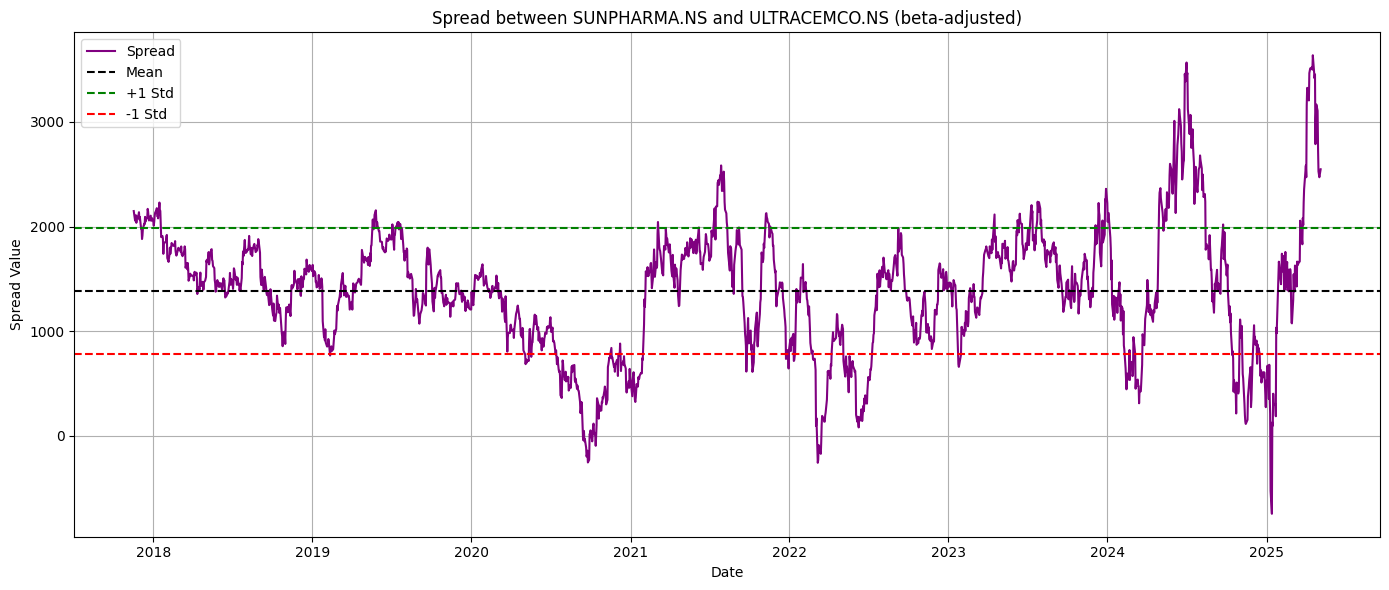

In [25]:


# Plotting the spread 
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(spread, label='Spread', color='purple', linewidth=1.5)
plt.axhline(spread.mean(), color='black', linestyle='--', label='Mean')
plt.axhline(spread.mean() + spread.std(), color='green', linestyle='--', label='+1 Std')
plt.axhline(spread.mean() - spread.std(), color='red', linestyle='--', label='-1 Std')
plt.title(f'Spread between {stockOne} and {stockTwo} (beta-adjusted)')
plt.xlabel('Date')
plt.ylabel('Spread Value')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:


# Proceed with ADFS and KPSS tests

from statsmodels.tsa.stattools import adfuller, kpss

adf_result = adfuller(spread)

# adf_t_value = adf_result[0]
# critical_values = adf_result[4]

# If for any of the values, if adf_t_value < any of the critical values. Then we reject null hypothesis is adf test

adf_p_value = adf_result[1]

kpss_p_value = kpss(spread, regression='c')[1]

print(f"ADF p-value: {adf_p_value}")
print(f"KPSS p-value: {kpss_p_value}")
if adf_p_value < 0.05 and kpss_p_value > 0.05:
  print("The spread is stationary. Proceed with trading.")
else:
  print("The spread is not stationary. Do not trade this pair.")



ADF p-value: 0.0009543733843526448
KPSS p-value: 0.1
The spread is stationary. Proceed with trading.


C:\Users\sparsh\AppData\Local\Temp\ipykernel_6072\3556811162.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_p_value = kpss(spread, regression='c')[1]


In [27]:
# Finding the mean value of the spread to identify what is the average value
# of the difference b/w stock X and Y

mean_spread = spread.rolling(30).mean()
std_spread = spread.rolling(30).std()

zscore = (spread - mean_spread) / std_spread



In [28]:

## Checking if there are any opportunities with z-score > +2 ? or z-score < -2

extreme_zscores = zscore[(zscore > 2) | (zscore < -2)]

print(extreme_zscores)

if not extreme_zscores.empty:
  print("There are extreme z-score entries (> 2 or < -2).")
else:
  print("No extreme z-score entries found.")


Date
2018-01-15    2.160453
2018-01-19   -2.756317
2018-01-22   -2.401692
2018-01-23   -2.418662
2018-01-24   -3.266103
                ...   
2025-04-02    2.012595
2025-04-03    3.030496
2025-04-04    2.796146
2025-04-07    2.367363
2025-04-09    2.119182
Length: 241, dtype: float64
There are extreme z-score entries (> 2 or < -2).


In [ ]:
# Individual stocks mean reversion ???